# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

# Constants

In [2]:
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read Data

In [3]:
dataset_path = Path().resolve() / "wine"
dataset_path
df_red = pd.read_csv(dataset_path / "winequality-red.csv", sep=';')
df_white = pd.read_csv(dataset_path / "winequality-white.csv", sep=';')
df_red['color'] = 1
df_white['color'] = 0
df = pd.concat([df_red, df_white], ignore_index=True)

In [4]:
X = df.drop('quality', axis=1).values
y = df['quality'].values

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train - 3, dtype=torch.long).squeeze()
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val - 3, dtype=torch.long).squeeze()

# Substract 3 because quality is from 3 to 9, and we want it from 0 to 6

In [8]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [9]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y))

# Prepare pipeline

In [10]:
class MLP(nn.Module):
    def __init__(self, hidden_layers : list[int] = [64, 32], activation = nn.ReLU):
        super().__init__()
        layers = []
        in_dim = n_features
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation())
            in_dim = h
        layers.append(nn.Linear(in_dim, n_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [11]:
def train_model(model: nn.Module, optimizer: torch.optim, epochs: int, lr: float):
    criterion = nn.CrossEntropyLoss()
    opt = optimizer(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()*xb.size(0)
        avg_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        xb_val,yb_val = next(iter(val_loader))
        with torch.no_grad():
            logits = model(xb_val)
            val_loss = criterion(logits, yb_val).item()
            preds = torch.argmax(logits, dim=1)
            acc = (preds == yb_val).float().mean().item()

        if ep % 10 == 0 or ep == epochs-1:
            print(f"Epoch {ep:02d} | train_loss={avg_loss:.4f} val_loss={val_loss:.4f} acc={acc:.4f}")

    return model

In [12]:
configs = [
    {
        "hidden" : [64, 32],
        "act"    : nn.ReLU,
        "opt"    : torch.optim.AdamW,
        "lr"     : 1e-3,
    },
    {
        "hidden" : [128, 64, 32],
        "act"    : nn.ReLU,
        "opt"    : torch.optim.Adam,
        "lr"     : 5e-4,
    },
    {
        "hidden" : [128, 64],
        "act"    : nn.Tanh,
        "opt"    : torch.optim.AdamW,
        "lr"     : 1e-3,
    },
]

best_model = None
best_acc = 0

for i, cfg in enumerate(configs):
    print("Config:", cfg)
    model = MLP(hidden_layers=cfg["hidden"], activation=cfg["act"])
    trained_model = train_model(model, cfg["opt"], epochs=EPOCHS, lr=cfg["lr"])

    trained_model.eval()
    xb_val, yb_val = next(iter(val_loader))
    with torch.no_grad():
        logits = trained_model(xb_val)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == yb_val).float().mean().item()

    print(f"Val accuracy = {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_model = trained_model

Config: {'hidden': [64, 32], 'act': <class 'torch.nn.modules.activation.ReLU'>, 'opt': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.001}
Epoch 00 | train_loss=1.3626 val_loss=1.1006 acc=0.4688
Epoch 10 | train_loss=0.9948 val_loss=1.0095 acc=0.5312
Epoch 20 | train_loss=0.9527 val_loss=1.0121 acc=0.5000
Epoch 30 | train_loss=0.9275 val_loss=1.0165 acc=0.5625
Epoch 40 | train_loss=0.9053 val_loss=1.0026 acc=0.5312
Epoch 49 | train_loss=0.8872 val_loss=0.9897 acc=0.5938
Val accuracy = 0.5938
Config: {'hidden': [128, 64, 32], 'act': <class 'torch.nn.modules.activation.ReLU'>, 'opt': <class 'torch.optim.adam.Adam'>, 'lr': 0.0005}
Epoch 00 | train_loss=1.4031 val_loss=1.1798 acc=0.3750
Epoch 10 | train_loss=0.9873 val_loss=1.0375 acc=0.4688
Epoch 20 | train_loss=0.9392 val_loss=0.9305 acc=0.5938
Epoch 30 | train_loss=0.9075 val_loss=0.9581 acc=0.5625
Epoch 40 | train_loss=0.8789 val_loss=0.9129 acc=0.6562
Epoch 49 | train_loss=0.8555 val_loss=0.9386 acc=0.5938
Val accuracy = 0.5938
Config: {'


Classification report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.35      0.16      0.22        43
           2       0.60      0.63      0.62       402
           3       0.58      0.71      0.64       597
           4       0.57      0.32      0.41       215
           5       0.00      0.00      0.00        36
           6       0.00      0.00      0.00         1

    accuracy                           0.58      1300
   macro avg       0.37      0.28      0.30      1300
weighted avg       0.56      0.58      0.56      1300



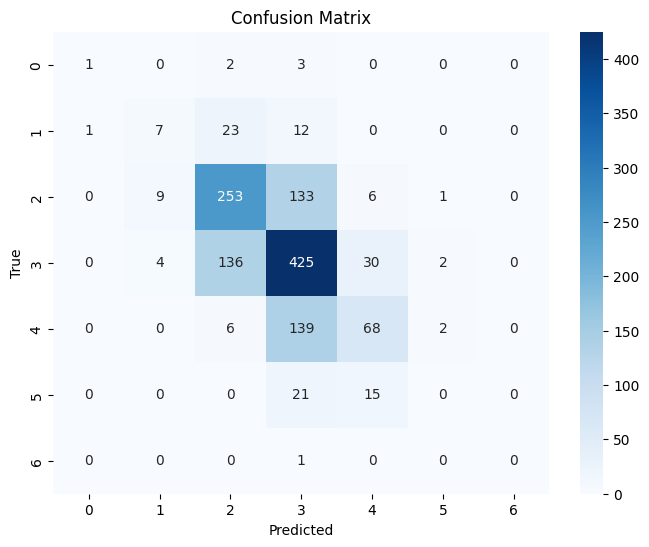

In [13]:
if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        xb, yb = val_loader.dataset.tensors
        preds = torch.argmax(best_model(xb), dim=1)

    print("\nClassification report:")
    print(classification_report(yb.numpy(), preds.numpy()))

    cm = confusion_matrix(yb.numpy(), preds.numpy())
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("No best model found.")

# Results

Лучше всего модель предсказывает quality=6 (на conf matrix выше классы на 3 меньше реальных).
Вообще не справлсяется с определением качества quality=8, 9
В целом, модель хорошо предсказывает качество в районе 6